# Modeling and Simulation in Python

Chapter 11: Rotation

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### Rolling paper

We'll start by loading the units we need.

In [2]:
radian = UNITS.radian
m = UNITS.meter
s = UNITS.second

And creating a `Condition` object with the system parameters

In [3]:
condition = Condition(Rmin = 0.02 * m,
                      Rmax = 0.055 * m,
                      L = 47 * m,
                      duration = 130 * s)

The following function estimates the parameter `k`, which is the increase in the radius of the roll for each radian of rotation. 

In [4]:
def estimate_k(condition):
    """Estimates the parameter `k`.
    
    condition: Condition with Rmin, Rmax, and L
    
    returns: k in meters per radian
    """
    unpack(condition)
    
    Ravg = (Rmax + Rmin) / 2
    Cavg = 2 * pi * Ravg
    revs = L / Cavg
    rads = 2 * pi * revs
    k = (Rmax - Rmin) / rads
    return k

As usual, `make_system` takes a `Condition` object and returns a `System` object.

In [5]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition with Rmin, Rmax, and L
    
    returns: System with init, k, and ts
    """
    unpack(condition)
    
    init = State(theta = 0 * radian,
                 y = 0 * m,
                 r = Rmin)
    
    k = estimate_k(condition)
    ts = linspace(0, duration, 101)
    
    return System(init=init, k=k, ts=ts)

Testing `make_system`

In [6]:
system = make_system(condition)
system

,value
init,theta 0 radian y 0 meter r ...
k,2.7925531914893616e-05 meter
ts,"[0.0 second, 1.3 second, 2.6 second, 3.9000000..."


In [7]:
system.init

,value
theta,0 radian
y,0 meter
r,0.02 meter


Now we can write a slope function based on the differential equations

$\omega = \frac{d\theta}{dt} = 10$

$\frac{dy}{dt} = r \frac{d\theta}{dt}$

$\frac{dr}{dt} = k \frac{d\theta}{dt}$


In [8]:
def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, y, r
    t: time
    system: System object with r, k
    
    returns: sequence of derivatives
    """
    theta, y, r = state
    unpack(system)
    
    omega = 10 * radian / s
    dydt = r * omega
    drdt = k * omega
    
    return omega, dydt, drdt

Testing `slope_func`

In [9]:
slope_func(system.init, 0*s, system)

(<Quantity(10.0, 'radian / second')>,
 <Quantity(0.2, 'meter * radian / second')>,
 <Quantity(0.0002792553191489362, 'meter * radian / second')>)

Now we can run the simulation.

In [10]:
run_odeint(system, slope_func)

And look at the results.

In [11]:
system.results.tail()

,theta,y,r
124.8,1248.0,46.707064,0.054851
126.1,1261.0,47.422487,0.055214
127.4,1274.0,48.142630,0.055577
128.7,1287.0,48.867493,0.055940
130.0,1300.0,49.597074,0.056303


Extracting one time series per variable (and converting `r` to radians):

In [12]:
thetas = system.results.theta
ys = system.results.y
rs = system.results.r * 1000

Plotting `theta`

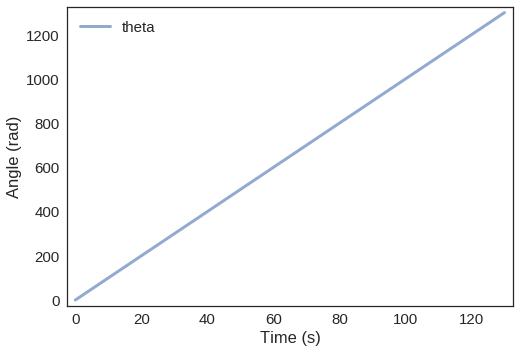

In [13]:
plot(thetas, label='theta')

decorate(xlabel='Time (s)',
         ylabel='Angle (rad)')

Plotting `y`

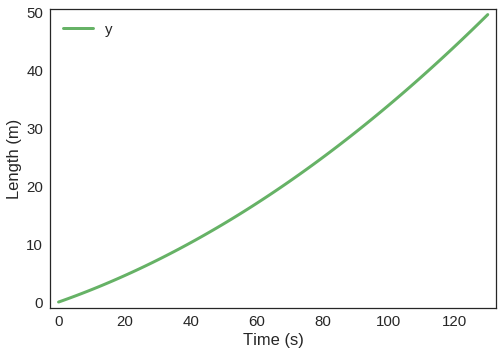

In [14]:
plot(ys, color='green', label='y')

decorate(xlabel='Time (s)',
         ylabel='Length (m)')

Plotting `r`

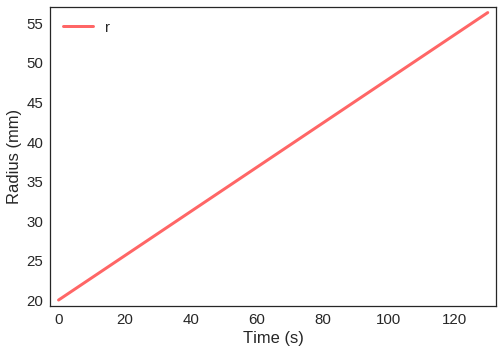

In [15]:
plot(rs, color='red', label='r')

decorate(xlabel='Time (s)',
         ylabel='Radius (mm)')

We can also see the relationship between `y` and `r`, which I derive analytically in the book.

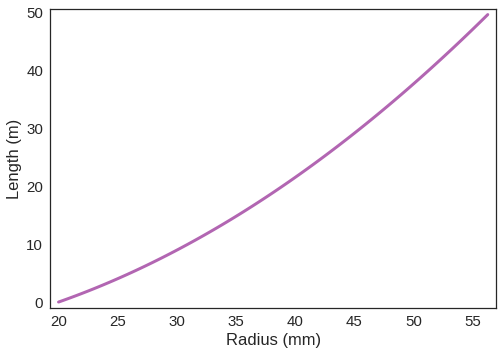

In [16]:
plot(rs, ys, color='purple')

decorate(xlabel='Radius (mm)',
         ylabel='Length (m)',
         legend=False)

And here's the figure from the book.

Saving figure to file chap11-fig01.pdf


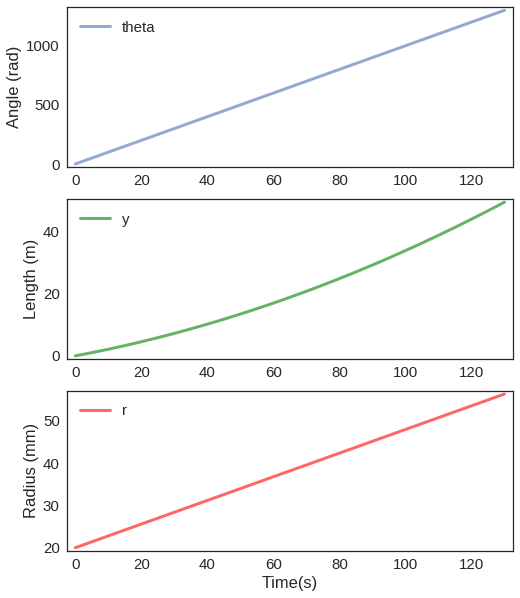

In [17]:
subplot(3, 1, 1)
plot(thetas, label='theta')
decorate(ylabel='Angle (rad)')

subplot(3, 1, 2)
plot(ys, color='green', label='y')
decorate(ylabel='Length (m)')

subplot(3, 1, 3)
plot(rs, color='red', label='r')

decorate(xlabel='Time(s)',
         ylabel='Radius (mm)')

savefig('chap11-fig01.pdf')

We can use interpolation to find the time when `y` is 47 meters.

In [18]:
T = interp_inverse(ys, kind='cubic')
t_end = T(47)
t_end

array(125.33333334940457)

At that point `r` is 55 mm, which is `Rmax`, as expected.

In [19]:
R = interpolate(rs, kind='cubic')
R(t_end)

array(55.00000000448797)

The total amount of rotation is 1253 rad.

In [20]:
THETA = interpolate(thetas, kind='cubic')
THETA(t_end)

array(1253.3333334940455)

### Unrolling

For unrolling the paper, we need more units:

In [21]:
kg = UNITS.kilogram
N = UNITS.newton

And a few more parameters in the `Condition` object.

In [22]:
condition = Condition(Rmin = 0.02 * m,
                      Rmax = 0.055 * m,
                      Mcore = 15e-3 * kg,
                      Mroll = 215e-3 * kg,
                      L = 47 * m,
                      tension = 2e-4 * N,
                      duration = 180 * s)

`make_system` computes `rho_h`, which we'll need to compute moment of inertia, and `k`, which we'll use to compute `r`.

In [23]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition with Rmin, Rmax, Mcore, Mroll,
                              L, tension, and duration
    
    returns: System with init, k, rho_h, Rmin, Rmax,
                         Mcore, Mroll, ts
    """
    unpack(condition)
    
    init = State(theta = 0 * radian,
                 omega = 0 * radian/s,
                 y = L)
    
    area = pi * (Rmax**2 - Rmin**2)
    rho_h = Mroll / area
    k = (Rmax**2 - Rmin**2) / 2 / L / radian    
    ts = linspace(0, duration, 101)
    
    return System(init=init, k=k, rho_h=rho_h,
                  Rmin=Rmin, Rmax=Rmax,
                  Mcore=Mcore, Mroll=Mroll, 
                  ts=ts)

Testing `make_system`

In [24]:
system = make_system(condition)
system

,value
init,theta 0 radian omega 0.0 radi...
k,2.7925531914893616e-05 meter / radian
rho_h,26.07109543981524 kilogram / meter ** 2
Rmin,0.02 meter
Rmax,0.055 meter
Mcore,0.015 kilogram
Mroll,0.215 kilogram
ts,"[0.0 second, 1.8 second, 3.6 second, 5.4 secon..."


In [25]:
system.init

,value
theta,0 radian
omega,0.0 radian / second
y,47 meter


Here's how we compute `I` as a function of `r`:

In [26]:
def moment_of_inertia(r, system):
    """Moment of inertia for a roll of toilet paper.
    
    r: current radius of roll in meters
    system: System object with Mcore, rho, Rmin, Rmax
    
    returns: moment of inertia in kg m**2
    """
    unpack(system)
    Icore = Mcore * Rmin**2   
    Iroll = pi * rho_h / 2 * (r**4 - Rmin**4)
    return Icore + Iroll

When `r` is `Rmin`, `I` is small.

In [27]:
moment_of_inertia(system.Rmin, system)

<Quantity(6e-06, 'kilogram * meter ** 2')>

As `r` increases, so does `I`.

In [28]:
moment_of_inertia(system.Rmax, system)

<Quantity(0.00037418750000000006, 'kilogram * meter ** 2')>

Here's the slope function.

In [29]:
def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, omega, y
    t: time
    system: System object with Rmin, k, Mcore, rho_h, tension
    
    returns: sequence of derivatives
    """
    theta, omega, y = state
    unpack(system)
    
    r = sqrt(2*k*y + Rmin**2)
    I = moment_of_inertia(r, system)
    tau = r * tension
    alpha = tau / I
    dydt = -r * omega
    
    return omega, alpha, dydt      

Testing `slope_func`

In [30]:
slope_func(system.init, 0*s, system)

(<Quantity(0.0, 'radian / second')>,
 <Quantity(0.02939702689159846, 'newton / kilogram / meter / radian ** 0.5')>,
 <Quantity(-0.0, 'meter * radian ** 0.5 / second')>)

Now we can run the simulation.

In [31]:
run_odeint(system, slope_func)

And look at the results.

In [32]:
system.results.tail()

,theta,omega,y
172.8,503.376998,6.830222,22.852269
174.6,515.788219,6.960580,22.346268
176.4,528.437150,7.094376,21.835001
178.2,541.330151,7.231802,21.318468
180.0,554.473940,7.373066,20.796665


Extrating the time series

In [33]:
thetas = system.results.theta
omegas = system.results.omega
ys = system.results.y

Plotting `theta`

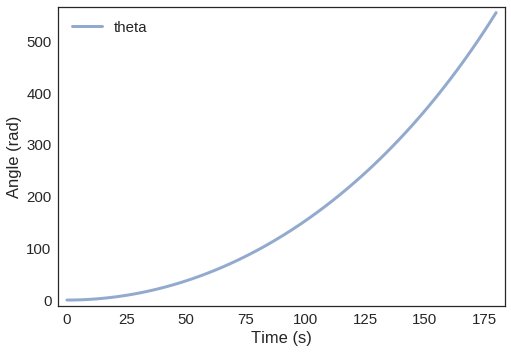

In [34]:
plot(thetas, label='theta')

decorate(xlabel='Time (s)',
         ylabel='Angle (rad)')

Plotting `omega`

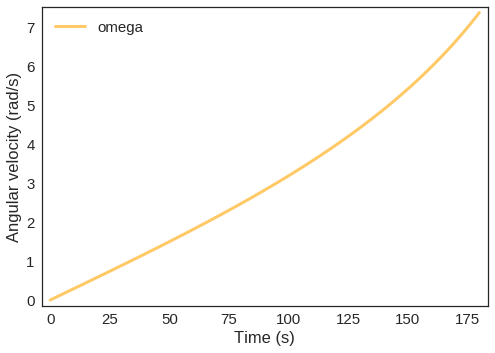

In [35]:
plot(omegas, color='orange', label='omega')

decorate(xlabel='Time (s)',
         ylabel='Angular velocity (rad/s)')

Plotting `y`

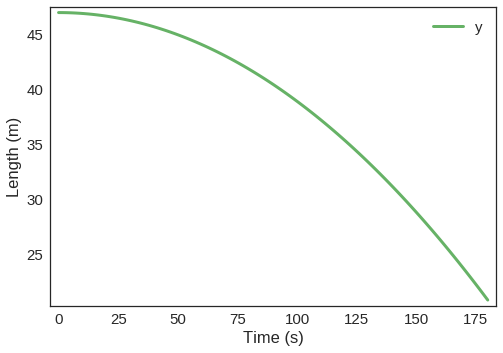

In [36]:
plot(ys, color='green', label='y')

decorate(xlabel='Time (s)',
         ylabel='Length (m)')

Here's the figure from the book.

Saving figure to file chap11-fig02.pdf


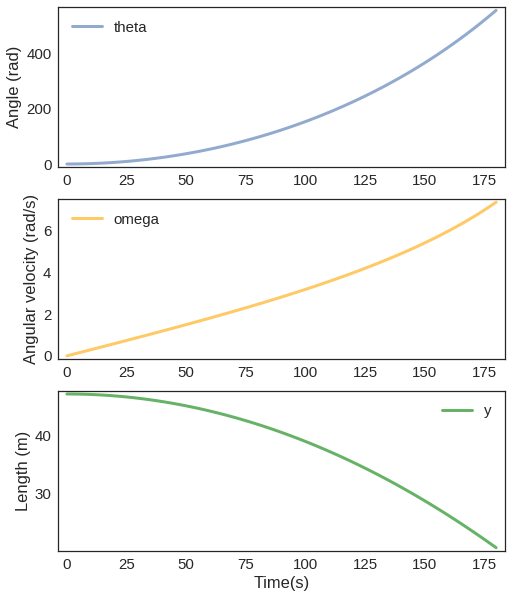

In [37]:
subplot(3, 1, 1)
plot(thetas, label='theta')
decorate(ylabel='Angle (rad)')

subplot(3, 1, 2)
plot(omegas, color='orange', label='omega')
decorate(ylabel='Angular velocity (rad/s)')

subplot(3, 1, 3)
plot(ys, color='green', label='y')

decorate(xlabel='Time(s)',
         ylabel='Length (m)')

savefig('chap11-fig02.pdf')

### Yo-yo

**Exercise:**  Simulate the descent of a yo-yo.  How long does it take to reach the end of the string?

I provide a `Condition` object with the system parameters:

* `Rmin` is the radius of the axle.  `Rmax` is the radius of the axle plus rolled string.

* `Rout` is the radius of the yo-yo body.  `mass` is the total mass of the yo-yo, ignoring the string.  

* `L` is the length of the string.

* `g` is the acceleration of gravity.

In [38]:
condition = Condition(Rmin = 8e-3 * m,
                      Rmax = 16e-3 * m,
                      Rout = 35e-3 * m,
                      mass = 50e-3 * kg,
                      L = 1 * m,
                      g = 9.8 * m / s**2,
                      duration = 1 * s)

Here's a `make_system` function that computes `I` and `k` based on the system parameters.

I estimated `I` by modeling the yo-yo as a solid cylinder with uniform density ([see here](https://en.wikipedia.org/wiki/List_of_moments_of_inertia)).  In reality, the distribution of weight in a yo-yo is often designed to achieve desired effects.  But we'll keep it simple.

In [39]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition with Rmin, Rmax, Rout, 
                              mass, L, g, duration
    
    returns: System with init, k, Rmin, Rmax, mass,
                         I, g, ts
    """
    unpack(condition)
    
    init = State(theta = 0 * radian,
                 omega = 0 * radian/s,
                 y = L,
                 v = 0 * m / s)
    
    I = mass * Rout**2 / 2
    k = (Rmax**2 - Rmin**2) / 2 / L / radian    
    ts = linspace(0, duration, 101)
    
    return System(init=init, k=k,
                  Rmin=Rmin, Rmax=Rmax,
                  mass=mass, I=I, g=g,
                  ts=ts)

Testing `make_system`

In [40]:
system = make_system(condition)
system

,value
init,theta 0 radian omega 0.0 radi...
k,9.6e-05 meter / radian
Rmin,0.008 meter
Rmax,0.016 meter
mass,0.05 kilogram
I,3.0625000000000006e-05 kilogram * meter ** 2
g,9.8 meter / second ** 2
ts,"[0.0 second, 0.01 second, 0.02 second, 0.03 se..."


In [41]:
system.init

,value
theta,0 radian
omega,0.0 radian / second
y,1 meter
v,0.0 meter / second


Write a slope function for this system, using these results from the book:

$ r = \sqrt{2 k y + R_{min}^2} $ 

$ T      = m g I / I^*  $

$ a      = -m g r^2 / I^* $

$ \alpha  = m g r / I^*  $

where $I^*$ is the augmented moment of inertia, $I + m r^2$.

Hint: If `y` is less than 0, it means you have reached the end of the string, so the equation for `r` is no longer valid.  In this case, the simplest thing to do it return the sequence of derivatives `0, 0, 0, 0`

In [42]:
# Solution

def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, omega, y, v
    t: time
    system: System object with Rmin, k, I, mass
    
    returns: sequence of derivatives
    """
    theta, omega, y, v = state
    unpack(system)
    
    if y < 0 * m:
        return 0, 0, 0, 0
        
    r = sqrt(2*k*y + Rmin**2)
    alpha = mass * g * r / (I + mass * r**2)
    a = -r * alpha
        
    return omega, alpha, v, a        

Test your slope function with the initial conditions.

In [43]:
slope_func(system.init, 0*s, system)

(<Quantity(0.0, 'radian / second')>,
 <Quantity(180.54116292458264, '1 / radian ** 0.5 / second ** 2')>,
 <Quantity(0.0, 'meter / second')>,
 <Quantity(-2.888658606793322, 'meter / radian / second ** 2')>)

Then run the simulation.

In [44]:
run_odeint(system, slope_func)

Check the final conditions.  If things have gone according to plan, the final value of `y` should be close to 0.

In [45]:
system.results.tail()

,theta,omega,y,v
0.96,67.11465,144.630635,-1.143965e-08,-1.994692
0.97,67.11465,144.630635,-1.143965e-08,-1.994692
0.98,67.11465,144.630635,-1.143965e-08,-1.994692
0.99,67.11465,144.630635,-1.143965e-08,-1.994692
1.00,67.11465,144.630635,-1.143965e-08,-1.994692


Plot the results.

In [46]:
thetas = system.results.theta
ys = system.results.y

`theta` should increase and accelerate.

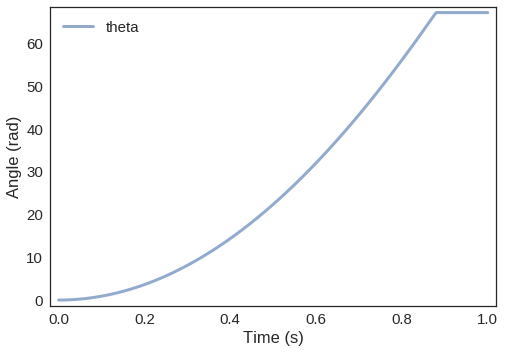

In [47]:
plot(thetas, label='theta')

decorate(xlabel='Time (s)',
         ylabel='Angle (rad)')

`y` should decrease and accelerate down.

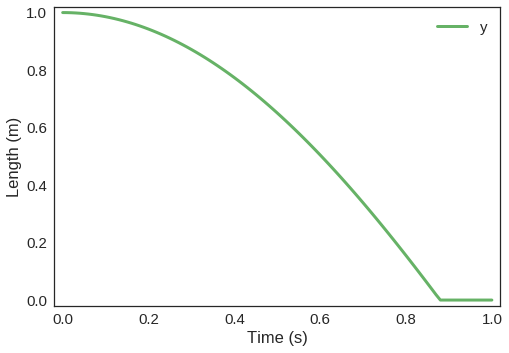

In [48]:
plot(ys, color='green', label='y')

decorate(xlabel='Time (s)',
         ylabel='Length (m)')